In [1]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

/Users/ana/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/ana/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
df_ejemplo = pd.read_csv('hr_limpio_con_nulos.csv', index_col=0)

In [3]:
# lo primero que vamos a hacer es calcular el porcentaje de nulos que tenemos para cada columna
(df_ejemplo.isnull().sum() / df_ejemplo.shape[0]) * 100

age                          0.000000
attrition                    0.000000
businesstravel              47.831475
dailyrate                    7.682776
department                  81.288724
distancefromhome             0.000000
education                    0.000000
educationfield              46.158612
employeenumber              26.703841
environmentsatisfaction      0.000000
gender                       0.000000
hourlyrate                   0.000000
jobinvolvement               0.000000
joblevel                     0.000000
jobrole                      0.000000
jobsatisfaction              0.000000
maritalstatus               40.334572
monthlyincome               52.230483
monthlyrate                  0.000000
numcompaniesworked           0.000000
overtime                    41.883519
percentsalaryhike            0.000000
performancerating           12.081784
relationshipsatisfaction     0.000000
stockoptionlevel             0.000000
totalworkingyears           32.589839
trainingtime

In [4]:
# lo convertimos a DataFrame
df_nulos = pd.DataFrame((df_ejemplo.isnull().sum() / df_ejemplo.shape[0]) * 100, columns = ["%_nulos"])

# filtramos el DataFrame para quedarnos solo con aquellas columnas que tengan nulos
df_nulos[df_nulos["%_nulos"] > 0]

,%_nulos
businesstravel,47.831475
dailyrate,7.682776
department,81.288724
educationfield,46.158612
employeenumber,26.703841
maritalstatus,40.334572
monthlyincome,52.230483
overtime,41.883519
performancerating,12.081784
totalworkingyears,32.589839


# Variable categóricas

In [ ]:
# Obtenemos la lista de columnas categóricas que tienen nulos
nulos_esta_cat = df[df.columns[df.isnull().any()]].select_dtypes(include = "O").columns
print("Las columnas categóricas que tienen nulos son : \n ")
print(nulos_esta_cat)

In [ ]:
# sacamos el 'value_counts()' de cada una de las columnas categóricas que tienen nulos para saber como es la distribución de sus categorías
for col in nulos_esta_cat:
    print(f"La distribución de las categorías para la columna {col.upper()}")
    display(df[col].value_counts() / df.shape[0])
    print("..........")

Segun los porcentajes de las categorias, si hay una categoria dominante reemplazamos por la moda, de lo contrario podemos hacer una categoria nueva  

In [ ]:
# lo primero que vamos a hacer es crear dos listas, una con los nombres de las columnas que reemplazaremos por la moda y otra para las columnas que reemplazaremos por una categoría nueva
columnas_moda = []
columnas_desconocido = []

Reemplazamos por la moda

In [ ]:

# iteramos por la lista creada en el paso anterior:
for columna in columnas_moda:
    
    # calculamos la moda para la columna por la que estamos iterando
    moda = df[col].mode()[0]    
    
    # utilizando el método fillna reemplazamos los valores nulos por la moda calculada en el paso anterior. 
    df[columna] = df[columna].fillna(moda)

# por último chequeamos si se han eliminado los nulos en las columnas de "marital" y "loan"
print("Después del reemplazo usando 'fillna' quedan los siguientes nulos")

df[columnas_moda].isnull().sum()

Agregamos una nueva categoria

In [ ]:
# iteramos por la lista de columnas a las que le vamos a cambiar los nulos por "Uknown"
for columna in columnas_desconocido:
    
    # reemplazamos los nulos por el valor Unknown para cada una de las columnas de la lista
    df[columna] = df[columna].fillna("Unknown")
    
# comprobamos si quedan nulos en las columnas categóricas. 
print("Después del reemplazo usando 'fillna' quedan los siguientes nulos")
df[columnas_desconocido].isnull().sum()

## Variables numéricas

In [5]:
# Obtenemos la lista de columnas numericas que tienen nulos
nulos_esta_num = df_ejemplo[df_ejemplo.columns[df_ejemplo.isnull().any()]].select_dtypes(include = np.number).columns
print("Las columnas numéricas que tienen nulos son : \n ")
print(nulos_esta_num)

Las columnas numéricas que tienen nulos son : 
 
Index(['dailyrate', 'employeenumber', 'monthlyincome', 'performancerating',
       'totalworkingyears', 'worklifebalance'],
      dtype='object')


In [6]:
# lo primero que vamos a hacer es calcular el número de nulos que tenemos en cada una de las columnas numericas
df_ejemplo[nulos_esta_num].isnull().sum() / df_ejemplo.shape[0]

dailyrate            0.076828
employeenumber       0.267038
monthlyincome        0.522305
performancerating    0.120818
totalworkingyears    0.325898
worklifebalance      0.066914
dtype: float64

Podemos ver los valores atipicos con diagrama de boxplot 

/Users/ana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

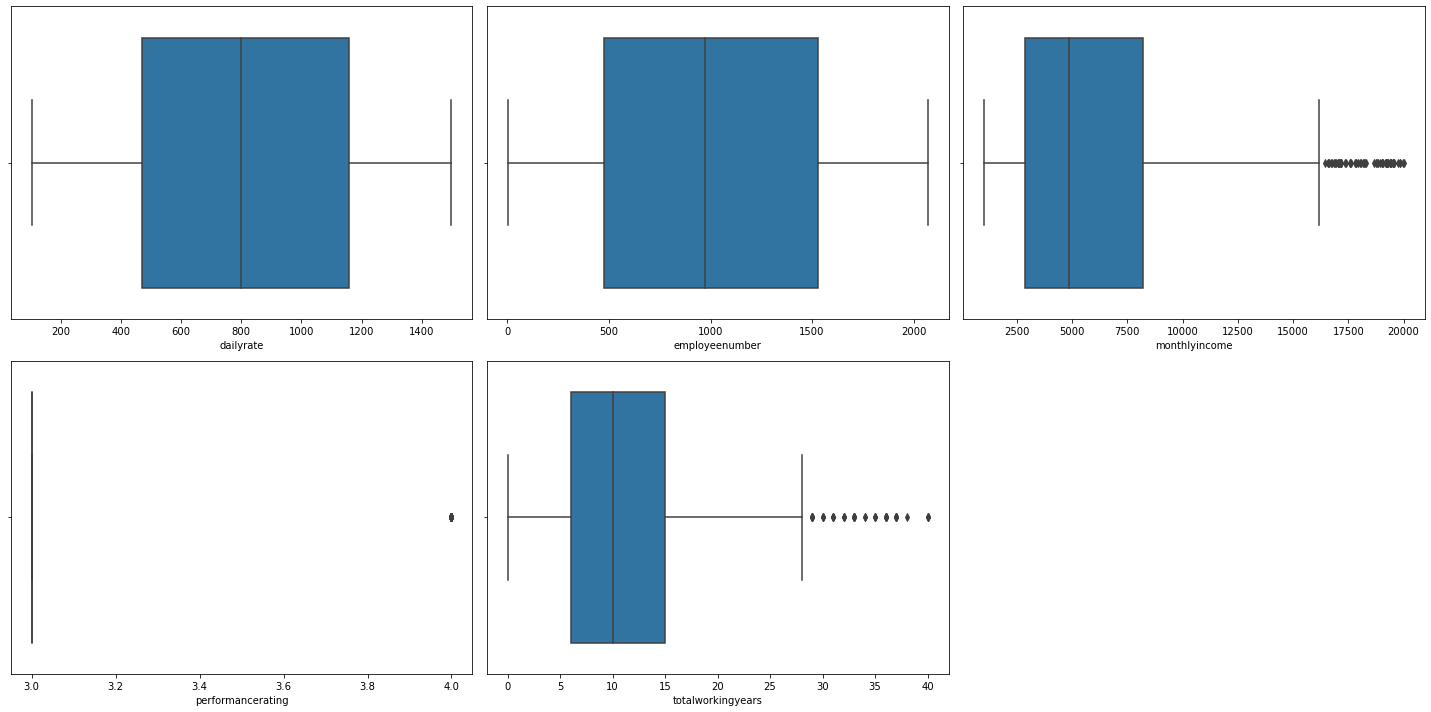

In [7]:
# lo siguiente que tendríamos que hacer es ver si dentro de las columnas donde tenemos nulos tenemos valores atípicos. 
# Para hacer esto lo mejor es usar visualización, sin embargo, todavía no hemos aprendido (lo haremos mañana). 
# Por lo tanto, el código que tenéis a continuación no es necesario que lo entendais. 

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,10)) 

axes = axes.flat

for indice, col in enumerate(nulos_esta_num):
    sns.boxplot(x = col, data = df_ejemplo, ax = axes[indice])
    
plt.tight_layout()
fig.delaxes(axes[-1]);

Aquellas columnas que tienen valores por debajo del 5-10% podemos optar por reemplazar por la media o mediana
 - Si la muestra tiene valores atipicos, la mediana es la opcion, de lo contrario podemos usar la media


Analisis de ambas columnas para el proyecto
porcentaje de nulos
dailyrate (tarifa diaria del empleado)  0.076828  representan 124 nulos de 1614 datos
employeenumber (numero de identificacion unico para el empleado) 0.267038 representan 431 nulos de 1614 datos
Tenemos mas de 500 valores duplicados 

In [28]:
df_ejemplo['employeenumber'].describe().round(1)

count    1183.0
mean     1000.3
std       596.4
min         2.0
25%       477.5
50%       972.0
75%      1530.0
max      2068.0
Name: employeenumber, dtype: float64

In [16]:
df_ejemplo['dailyrate'].describe().round(2).T

count    1490.00
mean      802.09
std       403.25
min       103.00
25%       468.25
50%       798.00
75%      1157.00
max      1499.00
Name: dailyrate, dtype: float64

In [19]:
df_ejemplo["dailyrate"].describe()[["mean", "50%"]]

mean    802.085235
50%     798.000000
Name: dailyrate, dtype: float64

In [ ]:
# para decidir si usamos la media o la mediana lo que haremos es hacer un describe de la columna para saber cuales son estos valores
df["contact_year"].describe()[["mean", "50%"]]

In [ ]:
media_conspriceidx = df[].mean()
print(f"La media de la columna 'conspriceidx' es: {round(media_conspriceidx, 2)}")

# aplicamos el método 'fillna()' a la columna
df[] = df[]fillna(media_conspriceidx)

# comprobamos los nulos para la columna
print(f"Después del 'fillna' tenemos {df['conspriceidx'].isnull().sum()} nulos")

In [ ]:
# lo siguiente que tenemos que hacer es introducir este array en nuestro DataFrame, en este caso sobreescribiremos la columna original. 
df["contact_year"] = contact_year_imputado

# por último comprobamos si tenemos nulos. 
print(f"Después del 'SimpleImputer' tenemos {df['contact_year'].isnull().sum()} nulos")

In [ ]:
# creamos el objeto de la clase del SimpleImputer
imputer_contact_year = SimpleImputer(strategy = "mean")

# ajustamos y transformamos los datos. 📌 Fijaos como hemos puesto dos corchetes en el nombre de la columna
contact_year_imputado = imputer_contact_year.fit_transform(df[["contact_year"]])

# comprobamos que es lo que nos devuelve este método. Nos devuelve un array. 
contact_year_imputado


Aquellas columnas con valores atipicos tendremos que usar los metodos de KNNImputer y/o IterativeImputer 

In [ ]:
# como vamos a crear columnas nuevas, vamos a hacer una copia del DataFrame usando el método 'copy()'
df_copia = df.copy()
df_copia.head(1)

IterativeImputer

In [ ]:
# hemos dicho que para las tres columnas restantes aplicaremos los dos métodos para luego compararlos, empezaremos por el IterativeImputer
# instanciamos las clases
imputer_iterative = IterativeImputer(max_iter = 20, random_state = 42)

# ajustamos y tranformamos los datos
imputer_iterative_imputado = imputer_iterative.fit_transform(df_copia[["age", "pdays", "euribor3m"]])

# comprobamos que es lo que nos devuelve, que en este caso es un array también
imputer_iterative_imputado

In [ ]:
# en este caso como vamos a aplicar los dos métodos sobre estas columnas vamos a crear dos columnas nuevas
df_copia[["age_iterative", "pdays_iterative", "euribor_iterative"]] = imputer_iterative_imputado

# comprobamos los nulos
print(f"Después del 'Iterative' tenemos: \n{df_copia[['age_iterative', 'pdays_iterative', 'euribor_iterative']].isnull().sum()} nulos")

KNNImputer

In [ ]:
# hagamos ahora lo mismo con el KNNImputer. NOTA, la ejecución de esta celda puede tardar un ratito

# instanciamos la clase del KNNImputer
imputer_knn = KNNImputer(n_neighbors = 5)

# ajustamos y transformamos los datos
imputer_knn_imputado = imputer_knn.fit_transform(df_copia[["age", "pdays", "euribor3m"]])

# comprobamos que es lo que nos devuelve, que sigue siendo un array
imputer_knn_imputado

In [ ]:
# por último nos queda añadir ese array al DataFrame como hemos hecho hasta ahora
df_copia[["age_knn", "pdays_knn", "euribor_knn"]] = imputer_knn_imputado


# comprobamos los nulos
print(f"Después del 'KNN' tenemos: \n{df_copia[['age_knn', 'pdays_knn', 'euribor_knn']].isnull().sum()} nulos")

Comparamos los datos con ambos metodos para decidir con cual nos quedamos

In [ ]:
df_copia.describe()[["age","age_iterative", "age_knn", "pdays", "pdays_iterative", "pdays_knn", "euribor3m", "euribor_iterative", "euribor_knn"]]

In [ ]:
#eliminar las columnas que ya no nos interesan para guardar el DataFrame 
df_copia.drop(["age", "pdays", "euribor3m", "age_knn" , "euribor_knn",  "pdays_iterative" ], axis = 1, inplace = True)

# ahora vamos a cambiar el nombre de las columnas que quedaron para que tengan el mismo nombre de origen
nuevo_nombre = {"age_iterative": "age",  'euribor_iterative': "euribor3m", "pdays_knn": "pdays"   }
df_copia.rename(columns = nuevo_nombre, inplace = True)

Guardamos el dataFrame modificado

In [ ]:

df_copia.to_csv()